## Image Classification on CIFAR-10
* Dataset : <https://www.kaggle.com/c/cifar-10>

In [1]:
import torch
from torchflare.datasets import ImageDataloader, show_batch, ImageDataset
import torchflare.callbacks as cbs
import pandas as pd

from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchflare.experiments import Experiment
import torchflare.metrics as metrics

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
df = pd.read_csv("dataset/trainLabels.csv")
classes = df.label.unique().tolist()
class_to_idx = {value: key for key, value in enumerate(classes)}
df.label = df.label.map(class_to_idx)
df.id = df.id.astype(str)
df = df.sample(frac=1).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [5]:
test_df = df.iloc[:10000, :]  # I took first 10000 entries as test data
data_df = df.iloc[10000:, :]
train_df, valid_df = train_test_split(data_df, test_size=0.3)

<IPython.core.display.Javascript object>

In [6]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

valid_transform = transforms.Compose([transforms.ToTensor()])

<IPython.core.display.Javascript object>

In [7]:
# Creating Training Dataloader.

train_dl = ImageDataloader.from_df(
    path="dataset/train",
    image_col="id",
    label_cols="label",
    augmentations=train_transform,
    df=train_df,
    extension=".png",
    convert_mode="RGB",
).get_loader(batch_size=32, shuffle=True, num_workers = 0)

# Creating Validation Dataloader.

valid_dl = ImageDataloader.from_df(
    path="dataset/train",
    image_col="id",
    label_cols="label",
    augmentations=valid_transform,
    df=valid_df,
    extension=".png",
    convert_mode="RGB",
).get_loader(batch_size=32, shuffle = False,num_workers=0)

# Creating Test Dataloader.

test_dl = ImageDataloader.from_df(
    path="dataset/train",
    image_col="id",
    label_cols=None,  # Setting label_cols as None since we wont have labels for test data.
    augmentations=valid_transform,
    df=test_df,
    extension=".png",
    convert_mode="RGB",
).get_loader(batch_size=16, num_workers=0)


<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


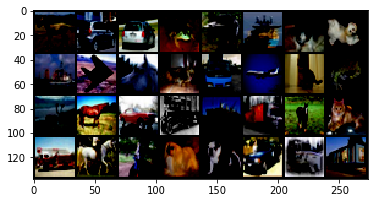

<IPython.core.display.Javascript object>

In [8]:
show_batch(train_dl)

In [9]:
class Net(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


<IPython.core.display.Javascript object>

In [10]:

metric_list = [metrics.Accuracy(num_classes=len(classes), multilabel=False)]

callbacks = [
    cbs.EarlyStopping(monitor="accuracy", mode = "max",patience=5),
    cbs.ModelCheckpoint(monitor="accuracy", mode = "max"),
    cbs.ReduceLROnPlateau(mode="max" , patience = 2)
]


<IPython.core.display.Javascript object>

In [12]:
exp = Experiment(
    num_epochs=2,
    fp16=True,
    device="cuda",
    seed=42,
)
exp.compile_experiment(
    module=Net,
    module_params = {"out_features" : 10},
    optimizer="Adam",
    optimizer_params = {"lr" : 3e-4},
    callbacks=callbacks,
    criterion="cross_entropy",
    metrics=metric_list,
    main_metric="accuracy",
)
exp.fit_loader(train_dl=train_dl, valid_dl=valid_dl)





Epoch: 1/2
Train: 875/875 [=========================]- 235s 269ms/step - train_loss: 1.8753 - train_accuracy: 0.3167
Valid: 375/375 [=========================]- 109s 291ms/step - val_loss: 2.1901 - val_accuracy: 0.2831

Epoch: 2/2
Train: 875/875 [=========================]- 10s 12ms/step - train_loss: 1.5769 - train_accuracy: 0.3408
Valid: 375/375 [=========================]- 3s 8ms/step - val_loss: 2.1514 - val_accuracy: 0.3223


<IPython.core.display.Javascript object>

In [14]:
exp.get_logs()

,Epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,1,1.875317,0.316714,2.190095,0.283150
1,2,1.576903,0.340824,2.151352,0.322325


<IPython.core.display.Javascript object>